<a href="https://colab.research.google.com/github/Krumpu/Homework_ICA/blob/main/HW_1_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - ANÁLISE DO DATASET E SUAS CARACTERÍSTICAS

Códigos para importação do conjunto de dados, para determinação do número de amostras, de preditores e quais serão as classes analisadas.

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

shutil.rmtree("./img")
os.makedirs('./img/unconditional_monovariate/', exist_ok=True)
os.makedirs('./img/conditional_monovariate/', exist_ok=True)


plt.style.use('_mpl-gallery')
plt.rcParams.update({'font.size': 20})
url = 'https://raw.githubusercontent.com/Krumpu/Homework_ICA/main/Data-Melbourne_F.csv'
df = pd.read_csv(url)

# We can remove "year", "month" and "day" columns,
# since we did no time series analysis today...
# "VG" is removed, we do not have any info about
df = df.drop(['SLP', 'VG', 'year', 'month', 'day'], axis=1)

# Transformando a unidade do consumo energético de kWh para MGh
df['total_grid'] = df['total_grid'].div(1000)

# Information about our data set
print('Number of Observations (N): ', df.shape[0])
print('Number of Predictor Variables (D): ', df.shape[1])

# Q diabos é isso abaix kaique??? Why?
print(df['COD'].describe())
print(df['BOD'].describe())

Number of Observations (N):  1382
Number of Predictor Variables (D):  15
count    1382.000000
mean      845.960434
std       145.416540
min       360.000000
25%       751.250000
50%       845.000000
75%       920.000000
max      1700.000000
Name: COD, dtype: float64
count    1382.000000
mean      382.061708
std        85.996012
min       140.000000
25%       330.000000
50%       360.000000
75%       422.980000
max       850.000000
Name: BOD, dtype: float64


## 1.1 - **Classes**

Como indicadores de economia/deseperdicio durante o tratamento, utilizaremos as métricas COD e BOD, que respectivamente significam Chemical Oxygen Demand (mg/L) e Biological Oxygen Demand (mg/L).\
\
Dessa forma, podemos dividir o intervalo desses indicadores em n partes, utilizando-as como classificação.\
\
A Chemical Oxygen Demand(COD), indica a quantidade de oxigênio utilizado durante a reação quimica para consumir contaminantes presentes. \
Já a Biological Oxygen Demand(BOD), é a unidade de medida utilizada para determinar a quantidade de oxigênio utilizado por organismos biológicos aeróbicos. \
Com os dois indicativos construiremos classes formadas da combinação dos dois intervalos criados pela média de COD e de BOD. \
\
Iremos dividir os nossos dados em 3 intervalos para cada um dos seguintes preditores:\
COD:\
  Baixo: 360 - 790;\
  Medio: 791 - 890;\
  Alto: 891 - 1700.\
\
BOD:\
  Baixo: 140 - 340;\
  Medio: 341 - 400;\
  Alto: 401 - 850.\
\
PP:\
  Sem chuva: <0.1;\
  Leve: 0.1 - 1;\
  Moderada: >1;\
\

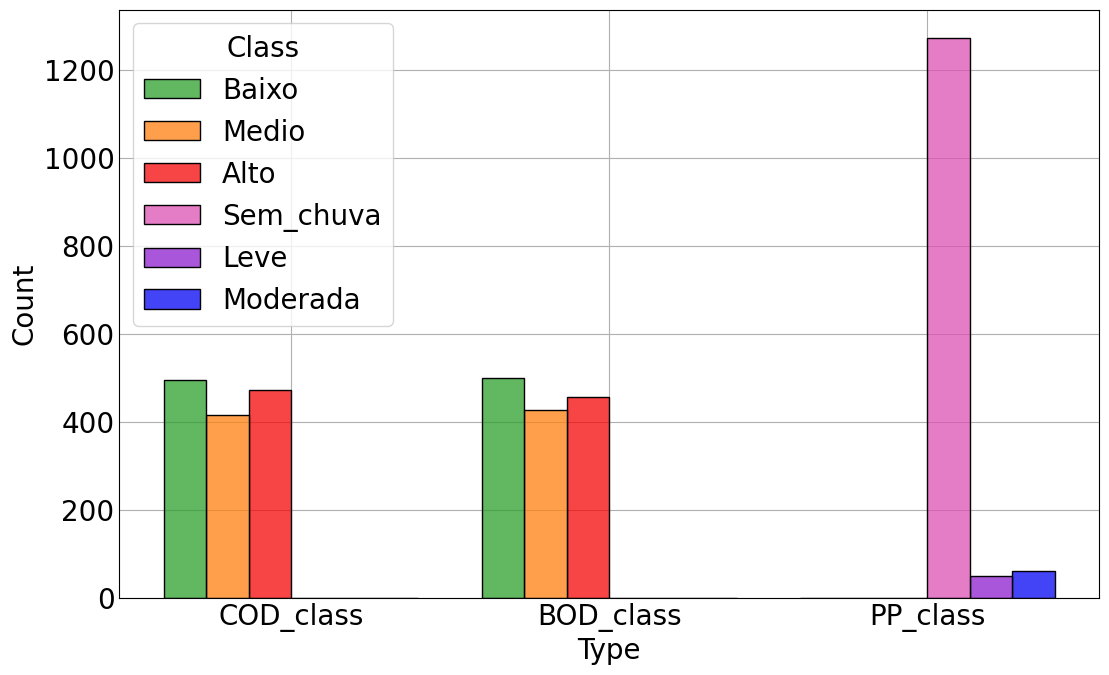

In [3]:
df.loc[(df['COD'] >= 360) & (df['COD'] <= 790), "COD_class"] = "Baixo"
df.loc[(df['COD'] >= 791) & (df['COD'] <= 890), "COD_class"] = "Medio"
df.loc[(df['COD'] >= 891) & (df['COD'] <= 1700), "COD_class"] = "Alto"

df.loc[(df['BOD'] >= 140) & (df['BOD'] <= 340), "BOD_class"] = "Baixo"
df.loc[(df['BOD'] >= 341) & (df['BOD'] <= 400), "BOD_class"] = "Medio"
df.loc[(df['BOD'] >= 401) & (df['BOD'] <= 850), "BOD_class"] = "Alto"

df.loc[df['PP'] < 0.1, "PP_class"] = "Sem_chuva"
df.loc[(df['PP'] >= 0.1) & (df['PP'] <= 1), "PP_class"] = "Leve"
df.loc[df['PP'] > 1, "PP_class"] = "Moderada"

df_classes = df[['COD_class', 'BOD_class', 'PP_class']].copy()

paleta_todas = {
    "Baixo": "#2ca02c",
    "Medio": "#ff7f0e",
    "Alto":  "#F50505",
    "Sem_chuva": "#DD50B3",
    "Leve": "#8E1ECF",
    "Moderada": "#0505F5",
    "nan": "#000000"
}

paleta_Xod = {
    "Baixo": "#2ca02c",
    "Medio": "#ff7f0e",
    "Alto":  "#F50505",
    "nan": "#000000"
}

paleta_pp = {
    "Sem_chuva": "#DD50B3",
    "Leve": "#8E1ECF",
    "Moderada": "#0505F5",
    "nan": "#000000"
}

# Class distribution
plt.figure(figsize=(10,6))
sns.histplot(
    data=df_classes.melt(var_name='Type', value_name='Class'),
    x='Type',
    hue='Class',
    hue_order=['Baixo', 'Medio', 'Alto', 'Sem_chuva', 'Leve', 'Moderada'],
    multiple='dodge',   # or 'stack'
    shrink=0.8,
    palette=paleta_todas
)
plt.show()



---
# 2 - ANÁLISE INCONDICIONAL MONOVARIADA

Análise de cada preditor individualmente. É a forma mais simples de analisar os dados

In [4]:
def analyze_dataset(df: pd.DataFrame):
    stats_analysis = pd.DataFrame(columns=['name', 'mean', 'std_deviation', 'skewness'])

    for index, predictor in enumerate(df.select_dtypes('number').columns):
        stats_analysis.loc[index] = [
            predictor,
            np.round(df[predictor].mean(), 2),
            np.round(df[predictor].std(), 2),
            np.round(df[predictor].skew(), 2),
        ]

    # For index starting at 1
    stats_analysis.index = stats_analysis.index + 1
    return stats_analysis


generated_files = []
for i, predictor in enumerate(df.select_dtypes('number').columns):
    fig, axs = plt.subplots(1, 2, figsize=(18,9))

    _, bins, _ = axs[0].hist(df[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::4], title=f'{predictor} histogram')
    axs[1].boxplot(df[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 1.0},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 1.0},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

    plt.tight_layout()

    filename = f'./img/unconditional_monovariate/plot_{predictor}.png'
    fig.savefig(filename, bbox_inches='tight')
    generated_files.append(filename)
    plt.close(fig)
analyze_dataset(df)

name    mean  std_deviation  skewness
1   avg_outflow    3.93           1.23      0.38
2    avg_inflow    4.51           1.44      3.75
3    total_grid  275.16          44.64     -0.15
4            Am   39.22           7.76      0.31
5           BOD  382.06          86.00      1.23
6           COD  845.96         145.42      0.74
7            TN   62.74           3.57     -0.26
8             T   15.04           5.40      0.55
9            TM   20.53           7.10      0.49
10           Tm   10.04           4.66      0.50
11            H   63.56          14.53     -0.81
12           PP    0.22           1.31      8.76
13           VV    9.10          16.32     22.20
14            V   19.48           7.14      0.83
15           VM   35.38          11.63      0.55

In [ ]:
# Compactação dos arquivos para fazer o download
# !zip -r plots.zip ./img

---
# 3 - ANÁLISE **CONDICIONAL** MONOVARIADA
Descrever e investigar como os preditores distribuem-se entre as classes

## 3.1 - CHEMICAL OXYGEN DEMAND (COD)

### 3.1.1 - BAIXO

In [5]:
def class_plot(predict_col: str, class_name: str):
  sub_df = df.loc[df_classes[predict_col] == class_name].copy()
  numeric_predictors = sub_df.select_dtypes(include=['number']).columns

  for predictor in numeric_predictors:
    fig, axs = plt.subplots(1, 2, figsize=(18,9))

    _, bins, _ = axs[0].hist(sub_df[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::4], title=f'{predictor} histogram')
    axs[1].boxplot(sub_df[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                        "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

    plt.tight_layout()

    filename = f'./img/conditional_monovariate/plot_{predictor}.png'
    fig.savefig(filename, bbox_inches='tight')
    generated_files.append(filename)
    plt.close(fig)

  print(analyze_dataset(sub_df))

# Analise Condicional do tipo  COD_Baixo
class_plot('COD_class', 'Baixo')

           name    mean  std_deviation  skewness
1   avg_outflow    3.96           1.21      0.86
2    avg_inflow    4.48           1.46      3.07
3    total_grid  275.68          47.25     -0.20
4            Am   36.34           7.96      0.32
5           BOD  337.74          57.49      0.79
6           COD  704.99          73.41     -1.44
7            TN   60.21           3.24     -2.19
8             T   14.11           5.08      0.88
9            TM   19.14           6.67      0.71
10           Tm    9.49           4.44      0.69
11            H   66.24          14.22     -0.81
12           PP    0.30           1.44      7.69
13           VV   10.76          25.50     15.92
14            V   19.68           7.06      0.95
15           VM   35.20          11.33      0.81


### 3.1.2 MÉDIO

In [6]:
# Analise Condicional do tipo  COD_Médio
class_plot('COD_class', 'Medio')

           name    mean  std_deviation  skewness
1   avg_outflow    3.94           1.21      0.33
2    avg_inflow    4.54           1.63      4.47
3    total_grid  270.74          43.94     -0.14
4            Am   40.35           7.58      1.03
5           BOD  385.20          67.19      0.73
6           COD  844.84          26.11      0.03
7            TN   63.15           2.19     -0.57
8             T   15.97           5.52      0.46
9            TM   21.86           7.28      0.47
10           Tm   10.60           4.81      0.41
11            H   63.43          14.36     -0.64
12           PP    0.28           1.56      7.59
13           VV    8.34           7.30      6.09
14            V   19.30           7.19      0.83
15           VM   35.47          11.69      0.60


### 3.1.3 - ALTO

In [ ]:
# Analise Condicional do tipo COD_Alto
class_plot('COD_class', 'Alto')

## 3.2 - BIOLOGICAL OXYGEN DEMAND (BOD)

### 3.2.1 - BAIXO

In [ ]:
# Analise Condicional do tipo BOD_Baixo
class_plot('BOD_class', 'Baixo')

### 3.1.5 - MÉDIO

In [ ]:
# Analise Condicional do tipo BOD_Medio
class_plot('BOD_class', 'Medio')

### 3.2.3 - ALTO

In [ ]:
# Analise Condicional do tipo BOD_Alto
class_plot('BOD_class', 'Alto')

## 3.3 - Chuva/Neve

### 3.3.1 - SEM CHUVA

In [ ]:
# Analise Condicional do tipo Sem_chuva
class_plot('PP_class', 'Sem_chuva')

### 3.3.2 - CHUVA LEVE

In [ ]:
# Analise Condicional do tipo (chuva) Leve
class_plot('PP_class', 'Leve')

### 3.3.3 - CHUVA MODERADA

In [ ]:
# Analise Condicional do tipo (chuva) Moderada
class_plot('PP_class', 'Moderada')

# 4 - ANÁLISE INCONDICIONAL **BIVARIADA**

### Descrever e investigar como os preditores distribuem-se entre si


           name    mean  std_deviation  skewness
1   avg_outflow    3.93           1.23      0.38
2    avg_inflow    4.51           1.44      3.75
3    total_grid  275.16          44.64     -0.15
4            Am   39.22           7.76      0.31
5           BOD  382.06          86.00      1.23
6           COD  845.96         145.42      0.74
7            TN   62.74           3.57     -0.26
8             T   15.04           5.40      0.55
9            TM   20.53           7.10      0.49
10           Tm   10.04           4.66      0.50
11            H   63.56          14.53     -0.81
12           PP    0.22           1.31      8.76
13           VV    9.10          16.32     22.20
14            V   19.48           7.14      0.83
15           VM   35.38          11.63      0.55


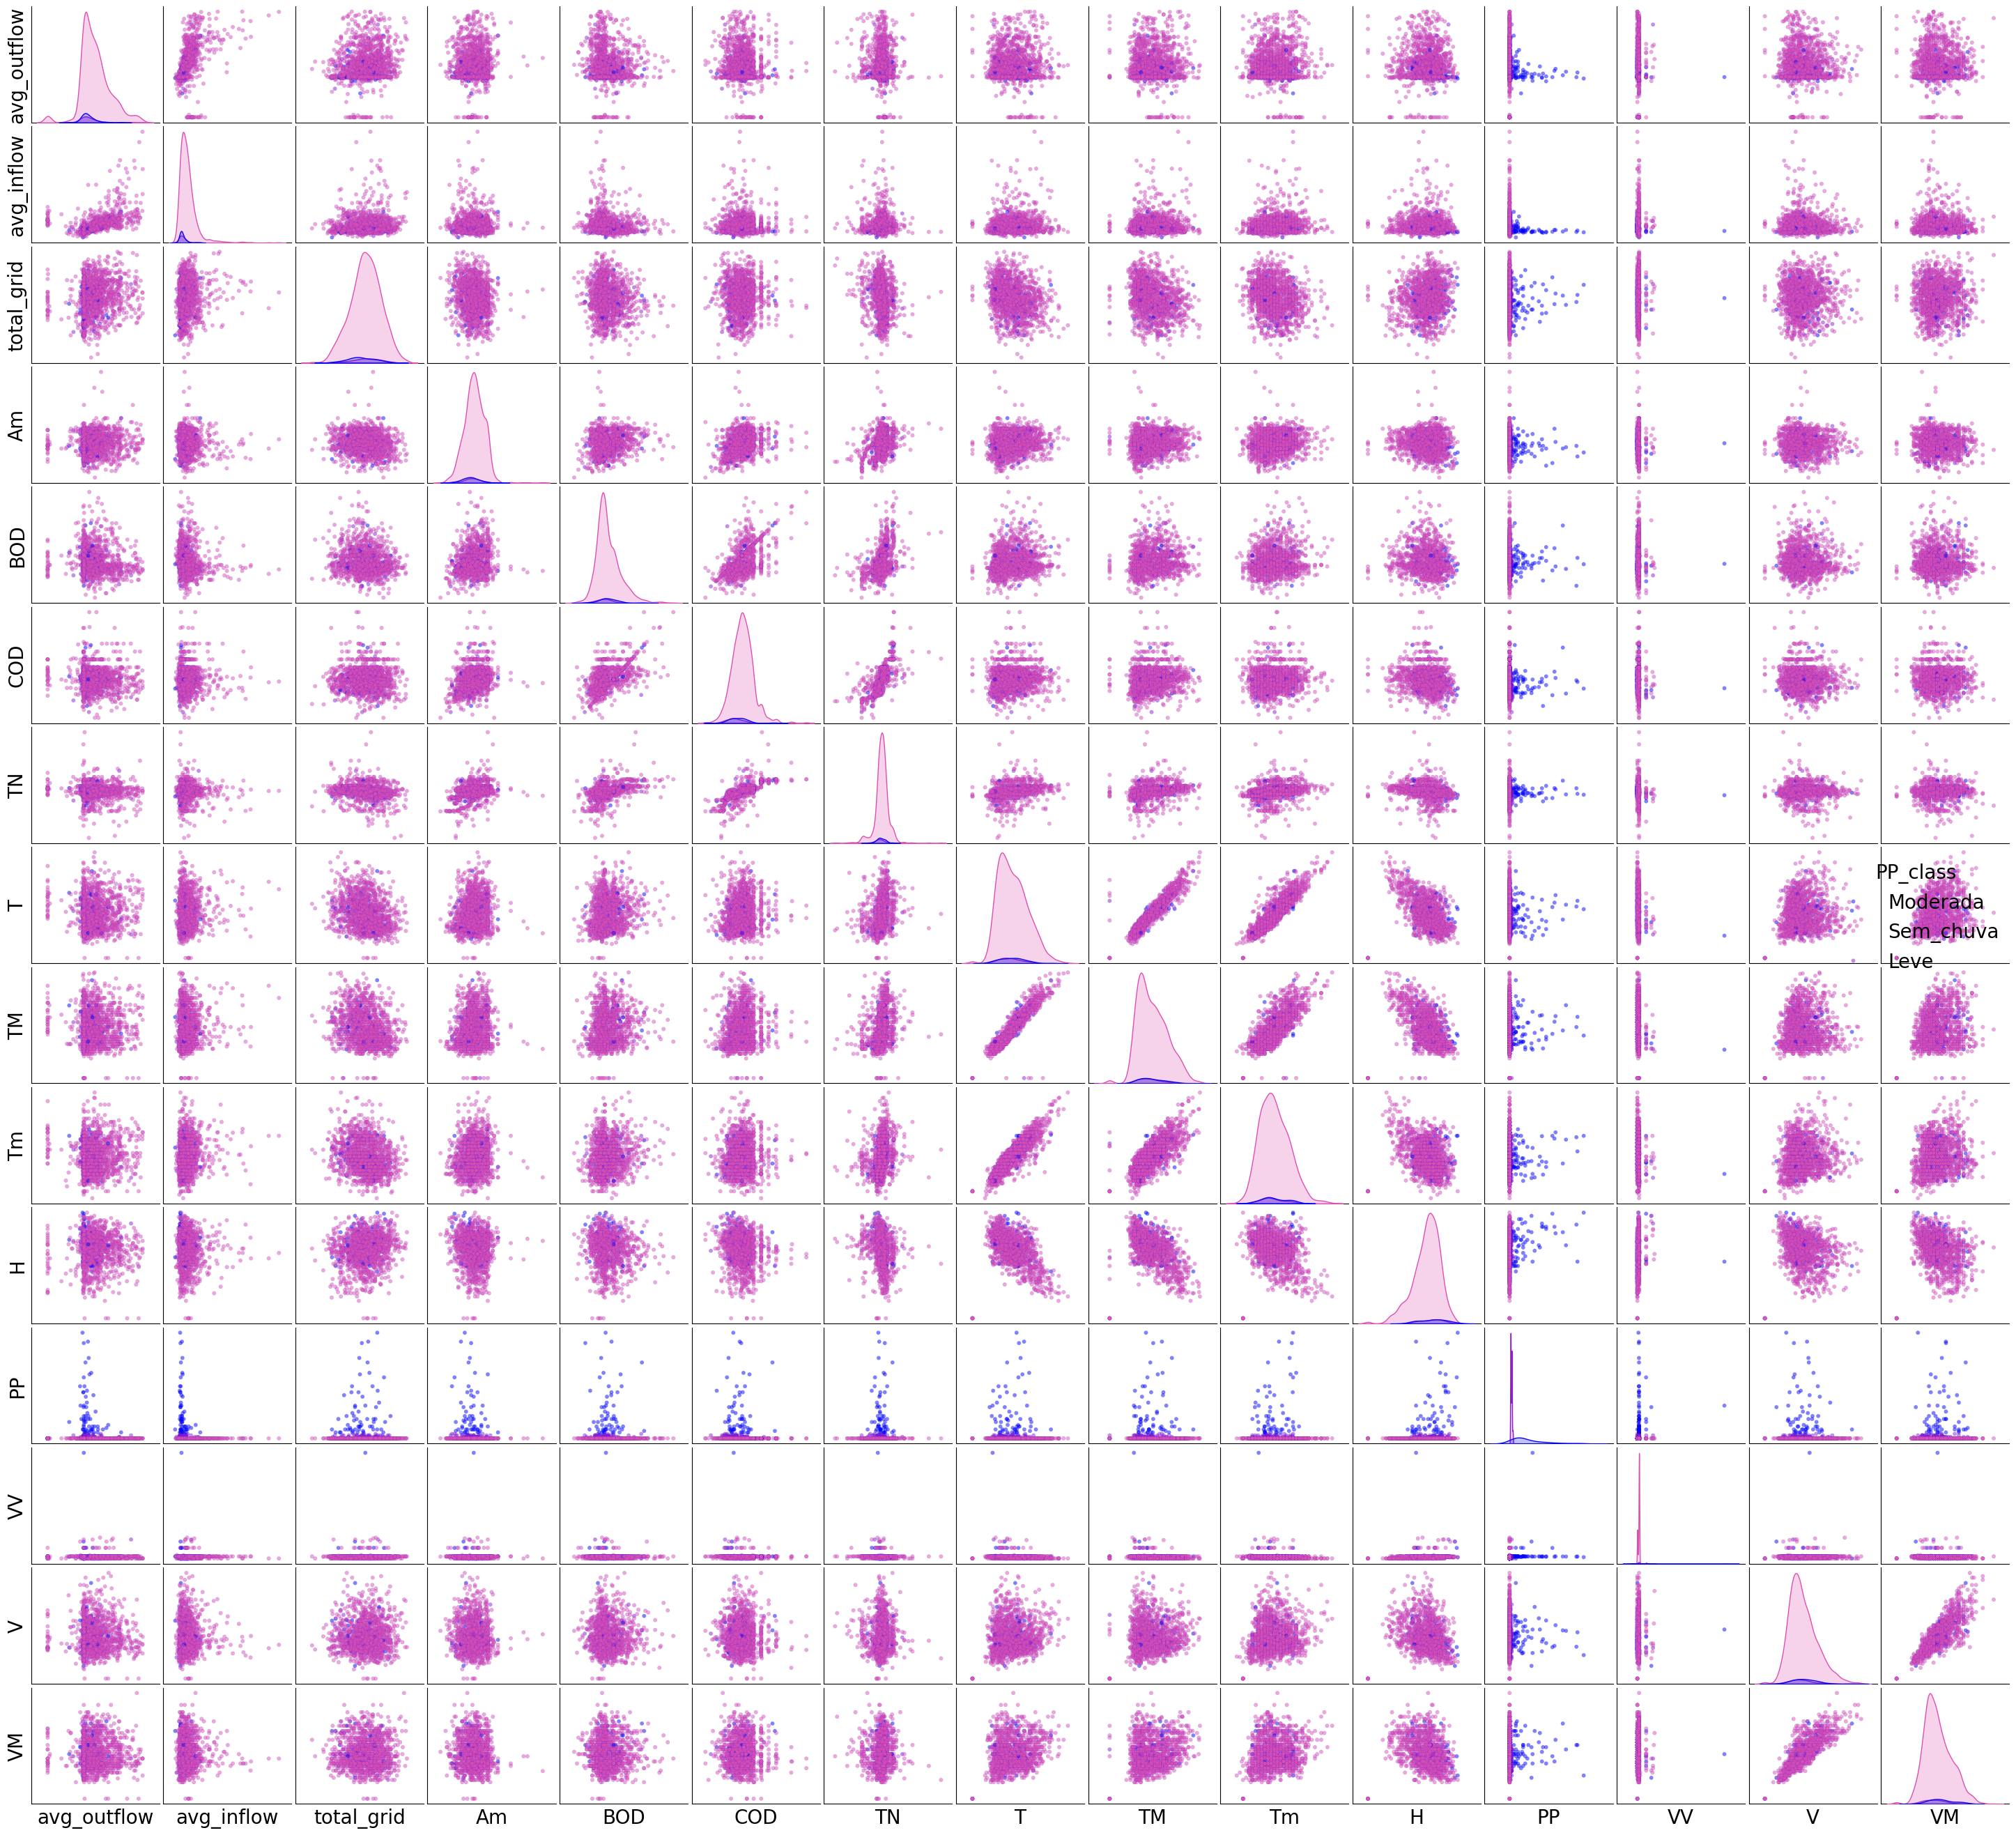

In [8]:
# Bivariate matrix plot wrap function

def bivariate_matrix(cl="", palette=None):

    print(analyze_dataset(df))

    pairgrid = sns.pairplot(
        df,
        height=1.75,
        aspect=1,
        plot_kws=dict(
            s=64,               # marker size
            alpha=0.5,          # transparency
            marker='.',         # marker type ('o', '^', '.', 'x', etc.)
            edgecolor="blue",   # thin black edge (set to 'none' to disable)
            linewidth=0.1,
        ),
        hue=cl,
        palette=palette
    )

    for ax in pairgrid.axes.flatten():
        if ax is not None:
            ax.grid(False)
            ax.set_facecolor("white")
            ax.set_xticks([])
            ax.set_yticks([])

    pairgrid.fig.tight_layout(pad=0.2)
    plt.show()

# Unconditional bi-variate analysis of the predictors
# Highlight on the PP classes!
bivariate_matrix('PP_class', paleta_pp)

# 5 - PCA

## Passos
1 - Normalização dos dados\
2 - Construção da matriz de covariancia\
3 - Determinação dos autovalores e autovetores da matriz de covariancia\
4 - Ordenação dos autovetores por autovalor
5 - Seleção

In [9]:
df_norm = df.select_dtypes('number')
df_norm = (df_norm - df_norm.mean())/df_norm.std()
df_norm.head()

avg_outflow  avg_inflow  total_grid        Am       BOD       COD  \
0    -0.805359   -1.331870   -2.224505 -1.574715 -0.198401 -0.797436   
1    -0.809428   -1.073462   -2.095295 -1.832394 -0.140259 -0.728668   
2    -0.815939   -0.890076   -1.638490  0.357877  0.417906 -0.068496   
3    -0.815939   -0.800466   -1.514590 -0.415160  0.557448  0.027779   
4    -0.824891   -0.494822   -1.620390  0.873235  1.464467  1.169328   

         TN         T        TM        Tm         H        PP       VV  \
0 -0.661643  0.789723  0.643829  0.550295 -0.520057  0.996165  0.05504   
1 -0.760214  0.382202  0.432465  0.485875 -0.038434 -0.166873  0.05504   
2  0.498805  0.326631  0.939739 -0.265700 -1.139286  0.024416  0.05504   
3  0.072597 -0.080890 -0.088899  0.228192 -1.001679 -0.166873  0.05504   
4  0.797877 -0.303175 -0.201627 -0.437489  0.099172 -0.166873  0.05504   

          V        VM  
0  1.039293  1.558419  
1 -0.712176 -0.652075  
2  1.739880  2.212106  
3  1.053304  0.302652  
4  0.156552 -0.015590

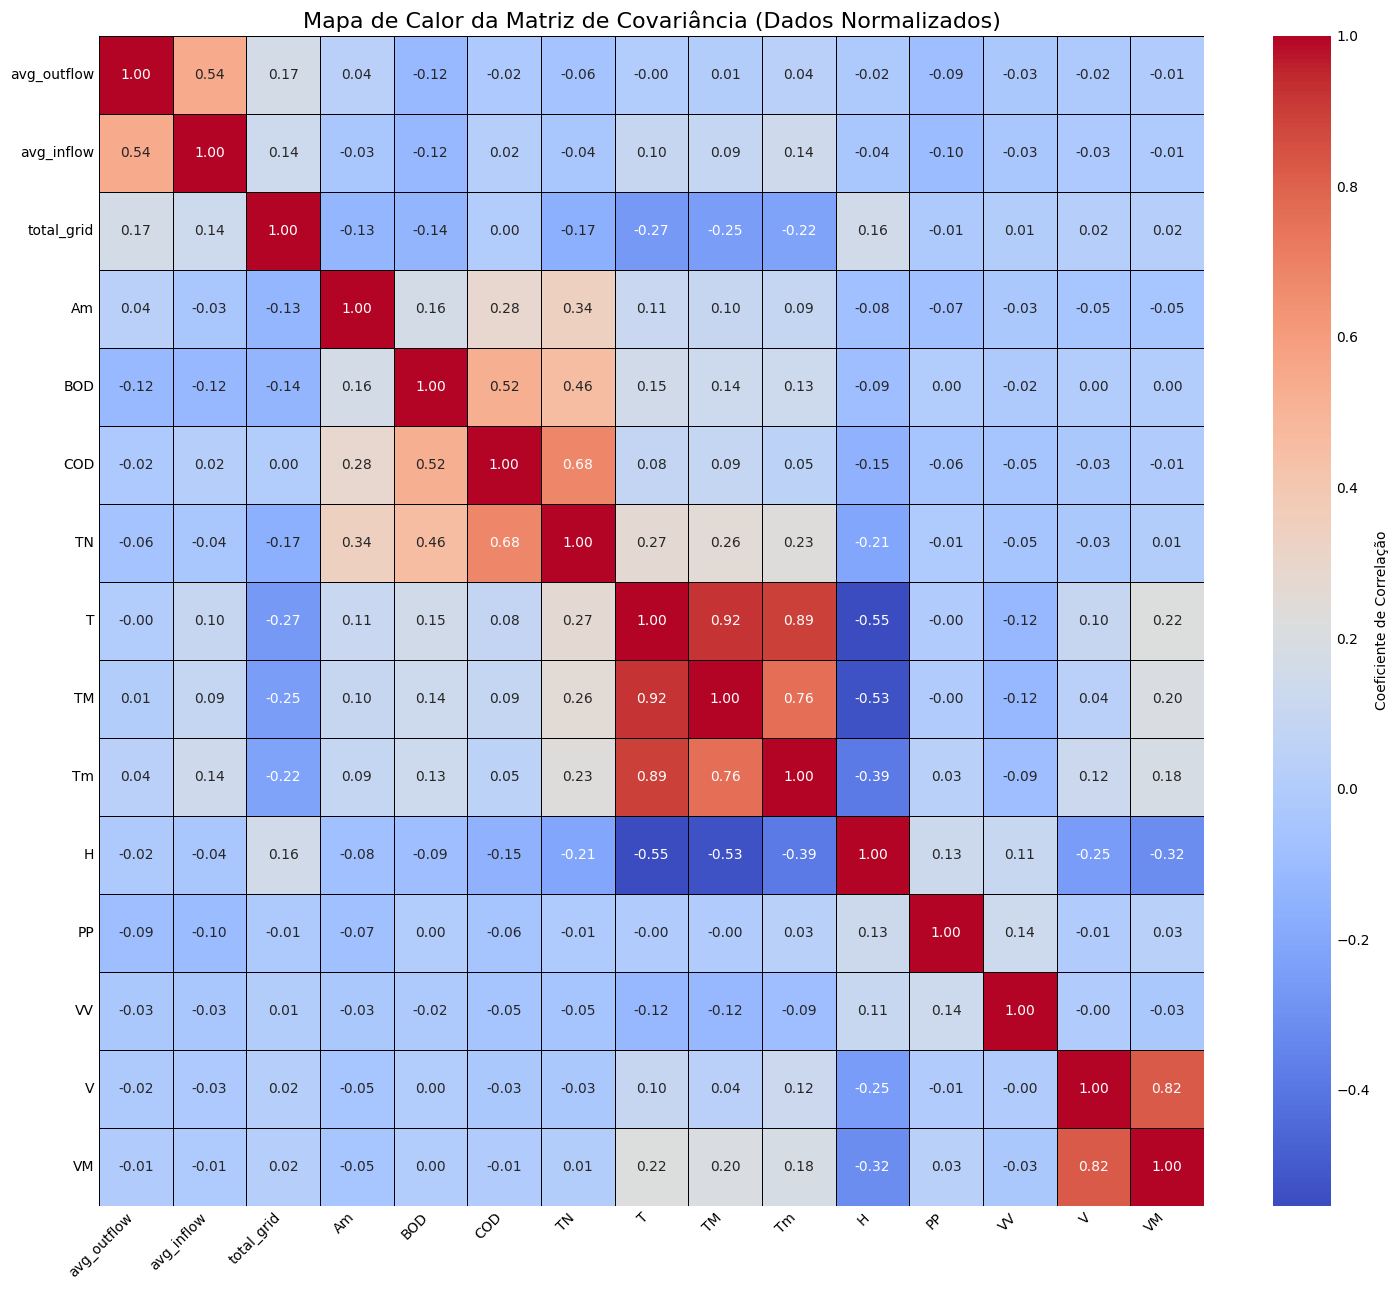

In [17]:
cov = df_norm.cov();
cov

plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(
    cov,
    annot=True,
    fmt=".2f", # Formata os valores para 2 casas decimais
    cmap="coolwarm",
    cbar_kws={'label': 'Coeficiente de Correlação'},
    linewidths=.5, # Adiciona linhas para melhor separação das células
    linecolor='black',
    ax=ax
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Mapa de Calor da Matriz de Covariância (Dados Normalizados)', fontsize=16)

plt.tight_layout()
plt.show()

In [11]:
autovalores, autovetores= np.linalg.eig(cov)

print(autovalores)
print(autovetores)

[3.60626052 2.1795335  1.7412522  1.57827871 1.11426204 0.93379309
 0.8386384  0.76593459 0.6145323  0.52076852 0.42551977 0.03520242
 0.1341205  0.26903492 0.24286851]
[[ 8.00357249e-03  1.49992964e-01  4.23493490e-01  4.55120213e-01
   1.68717735e-01 -1.31559480e-01 -1.35343372e-01 -1.75521641e-01
   4.17277327e-02  3.81655965e-01 -5.87563616e-01  1.10762886e-02
   1.24400061e-02 -5.30182106e-02 -1.83252063e-02]
 [-3.89534904e-02  1.65308003e-01  4.58757512e-01  4.08478908e-01
   1.88595630e-01 -2.17024708e-02 -8.20241744e-03 -2.55439586e-01
   8.90406131e-03 -2.95431987e-01  6.22932469e-01  9.49490143e-03
   6.35857904e-03  1.08883821e-01  7.13860811e-02]
 [ 1.79931322e-01  9.28578565e-02  5.17605836e-02  3.42541100e-01
   9.81606067e-02  4.86668505e-01  1.61743939e-01  7.23166694e-01
  -1.39033120e-01  8.43772173e-02  2.87172735e-02  9.27607415e-03
   1.89454762e-02  1.24874323e-01  7.91759589e-03]
 [-1.35928594e-01 -2.89852863e-01  3.18911576e-02  1.31405493e-01
  -7.65495072e-02 

In [12]:
#Toericamente não precisa fazer isso aqui, posso só pegar os 2 maiores autovalore, mas eu fiz por curiosidade

variancia_total = np.sum(autovalores)
variancia_exp = autovalores/variancia_total

print(variancia_exp)

vet_maiores = (autovetores[0], autovetores[1])

[0.24041737 0.14530223 0.11608348 0.10521858 0.07428414 0.06225287
 0.05590923 0.05106231 0.04096882 0.0347179  0.02836798 0.00234683
 0.00894137 0.01793566 0.01619123]


[3.60626052 2.1795335  1.7412522  1.57827871 1.11426204 0.93379309
 0.8386384  0.76593459 0.6145323  0.52076852 0.42551977 0.26903492
 0.24286851 0.1341205  0.03520242]


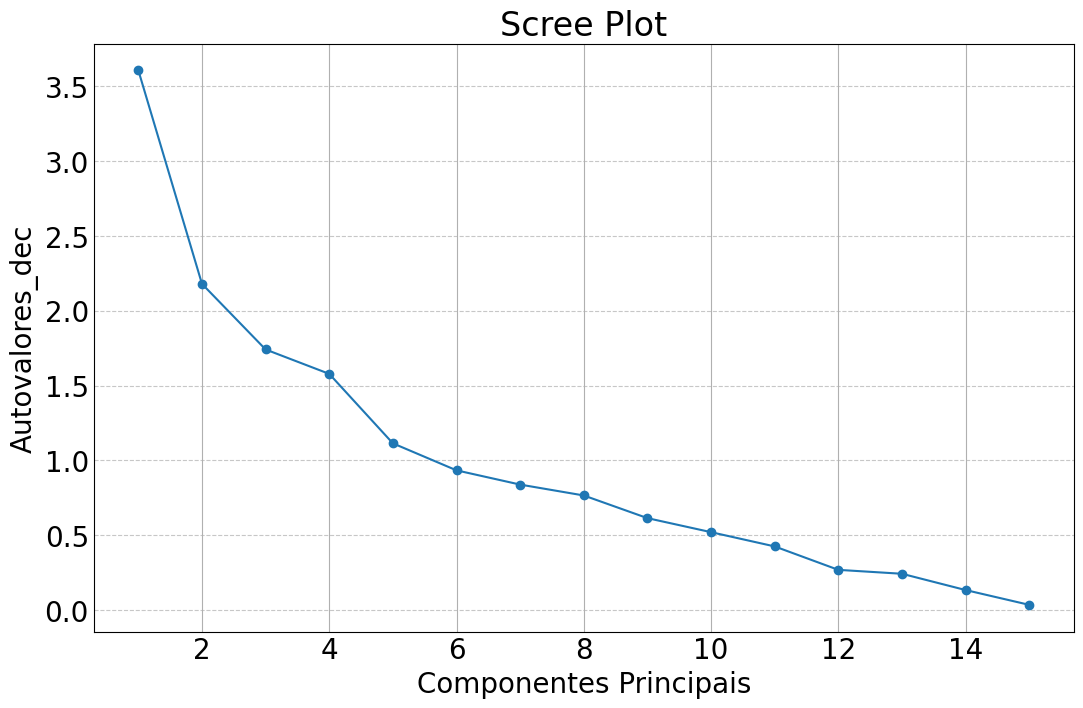

In [13]:
#screeplots
autovalores_dec = np.sort(autovalores)[::-1]
print(autovalores_dec)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autovalores_dec) + 1), autovalores_dec, marker='o', label='Autovalores_dec')
plt.xlabel('Componentes Principais')
plt.ylabel('Autovalores_dec')
plt.title('Scree Plot')
plt.grid(axis='y', linestyle='--', alpha=0.7)


O documento solicita somente os dois principais componentes

In [14]:
pca_df = np.matmul(vet_maiores,np.transpose(df_norm))
pca_df = np.transpose(pca_df)
pca_df

0         1
0    -1.372079 -2.315536
1    -1.506180 -2.246643
2    -0.240987 -1.002955
3    -0.252815 -1.397483
4    -0.573980  0.089308
...        ...       ...
1377 -0.086825 -0.131676
1378 -0.324051  0.976123
1379  0.039669  1.160885
1380  0.268536  1.205905
1381 -0.300404  0.110960

[1382 rows x 2 columns]